In [32]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from models import cmgn, icgn, icnn, mmgn
from torch.utils.data import TensorDataset, DataLoader
from verify_gradients import *
from trainers import trainer
plt.rcParams.update({
    "text.usetex": True,           
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman"],
})

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Different Models Presentation:

### Trivial Experimentation:
Here we will test our models on the standard problem mentioned in the paper which attempts to estimate the gradient field of $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ over the **unit square** such that:
\begin{equation}
f(x) = x_1^4 + \frac{x_2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^3}{2} -  \frac{x_2^3}{3}
\end{equation}

Its gradient is given by : 

\begin{equation*}
\nabla f(x) = g(x_1,x_2) = \begin{pmatrix}4x_1^3 + \frac{1}{2}x_2 \\ \frac{1}{2} + \frac{x_1}{2} + 3x_2 - x_2^2\end{pmatrix}
\end{equation*}

In [34]:
def func(z):
    x1 = z[:,0]
    x2 = z[:,1]
    return torch.stack([x1**4 + 0.5*x2 + 0.5 *x1*x2 + 1.5 * x2**2 - x2**3/3]).T

def gradient(z):
    x1 = z[:,0]
    x2= z[:,1]
    return torch.stack([4*x1**3 + 0.5*x2 , 0.5 + 0.5*x1 + 3*x2 - x2**2]).T

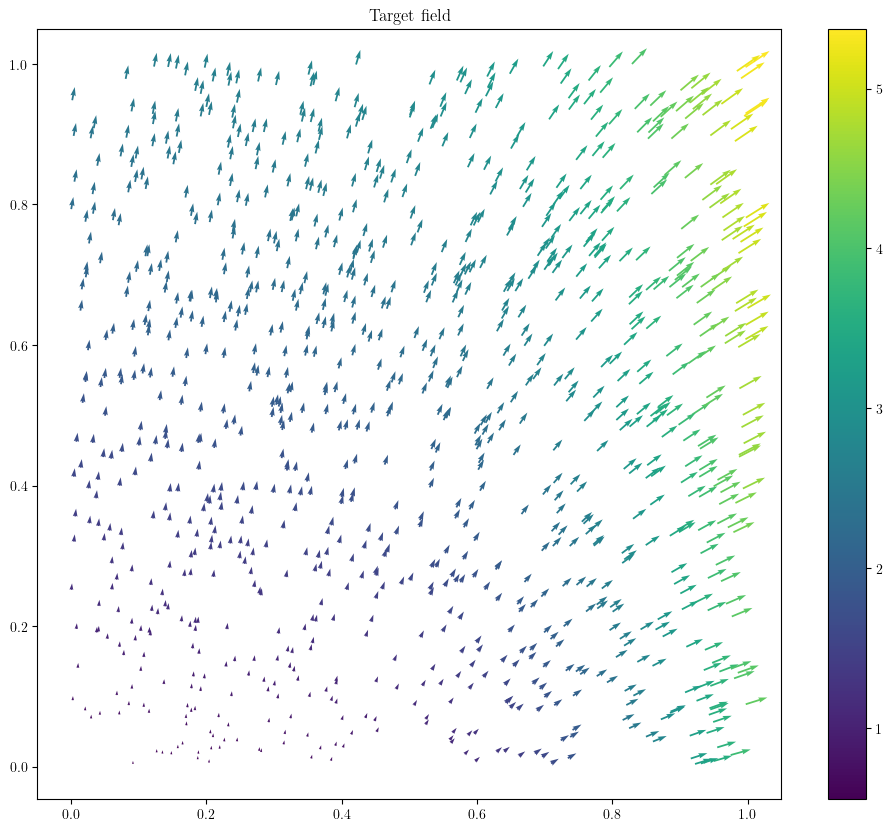

In [35]:
space = torch.rand(size=(1000,2))
fig,ax = plt.subplots(1,1,figsize=(12,10))

z = gradient(space)
p = ax.quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1), )
ax.set_title('Target field')
plt.colorbar(p)
plt.show()

In [36]:
input_dim = 2
output_dim = 2

# Models suggested by the Ppaer
model_CMGN = cmgn.C_MGN(input_dim=input_dim, hidden_dim=2, num_layers=2, output_dim=output_dim).to(device)
model_MMGN = mmgn.M_MGN(input_dim=input_dim, hidden_dim=4, num_layers=1, output_dim=output_dim).to(device)

# Benchmark Models
model_ICGN = icgn.I_CGN(input_dim=input_dim, hidden_dim=5, layers=0).to(device)
model_ICCN = icnn.I_CNN(input_dim=input_dim, hidden_dim=1, num_layers=19).to(device)

print("Number of parameters in C-MGN", sum(p.size().numel() for p in model_CMGN.parameters())) # ok
print("Number of parameters in M-MGN", sum(p.size().numel() for p in model_MMGN.parameters())) # fixed 22 in the paper
print("Number of parameters in I-CGN", sum(p.size().numel() for p in model_ICGN.parameters())) # ok
print("Number of parameters in I-CCN", sum(p.size().numel() for p in model_ICCN.parameters())) # KO 78 in the paper

Number of parameters in C-MGN 14
Number of parameters in M-MGN 22
Number of parameters in I-CGN 45
Number of parameters in I-CCN 76


In [37]:
def train(
        model, 
        optimizer,
        criterion,
        func,
        batch_size=1024,
        num_epochs=30,
        verbose=False

):
    for epoch in range(num_epochs):
        input = torch.rand(size=(batch_size,2))
        output_model = model(input)
        target = func(input)
        # Compute loss
        loss = criterion(output_model, target)
            
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and not epoch % 1000: 
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return model
    

In [9]:
# Define optimizer and loss function
data = torch.rand(10000,2)
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_CMGN.parameters(), lr=1e-3)
trained_CMGN = train(model_CMGN, optimizer, criterion, gradient, num_epochs=10000, verbose=True)

Epoch 0, Loss: 2.4843549728393555
Epoch 1000, Loss: 0.3177003860473633
Epoch 2000, Loss: 0.20771893858909607
Epoch 3000, Loss: 0.19329869747161865
Epoch 4000, Loss: 0.18533995747566223
Epoch 5000, Loss: 0.16298942267894745
Epoch 6000, Loss: 0.11706633865833282
Epoch 7000, Loss: 0.05997488647699356
Epoch 8000, Loss: 0.04585663601756096
Epoch 9000, Loss: 0.04571020230650902


In [12]:
# Define optimizer and loss function
data = torch.rand(10000,2)
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_MMGN.parameters(), lr=1e-3)
trained_MMGN = train(model_MMGN, optimizer, criterion, gradient, num_epochs=10000, verbose=True)

Epoch 0, Loss: 0.05418726056814194
Epoch 1000, Loss: 0.054697852581739426
Epoch 2000, Loss: 0.0539085790514946
Epoch 3000, Loss: 0.05319725722074509
Epoch 4000, Loss: 0.0511801652610302
Epoch 5000, Loss: 0.05286712944507599
Epoch 6000, Loss: 0.0509871281683445
Epoch 7000, Loss: 0.05261394381523132
Epoch 8000, Loss: 0.05211574211716652
Epoch 9000, Loss: 0.0507119745016098


In [8]:
# Define optimizer and loss function
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_ICGN.parameters(), lr=1e-3)
trained_ICGN = train(model_ICGN, optimizer, criterion, gradient, num_epochs=10000, verbose=True)

Epoch 0, Loss: 1.5688178539276123
Epoch 1000, Loss: 0.4472329616546631
Epoch 2000, Loss: 0.45301467180252075
Epoch 3000, Loss: 0.4202595055103302
Epoch 4000, Loss: 0.42333394289016724
Epoch 5000, Loss: 0.25264573097229004
Epoch 6000, Loss: 0.13716070353984833
Epoch 7000, Loss: 0.1920616328716278
Epoch 8000, Loss: 0.08057579398155212
Epoch 9000, Loss: 0.06769709289073944


In [18]:
# Define optimizer and loss function
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_ICCN.parameters(), lr=1e-3)
trained_ICCN = train(model_ICCN, optimizer, criterion, func, num_epochs=10000, verbose=True)

Epoch 0, Loss: 0.3824999928474426
Epoch 1000, Loss: 0.10995102673768997
Epoch 2000, Loss: 0.11198752373456955
Epoch 3000, Loss: 0.11497032642364502
Epoch 4000, Loss: 0.11026640236377716
Epoch 5000, Loss: 0.11193887144327164
Epoch 6000, Loss: 0.11516024172306061
Epoch 7000, Loss: 0.11330927908420563
Epoch 8000, Loss: 0.11072501540184021
Epoch 9000, Loss: 0.10801095515489578


C:\Users\mouad\AppData\Local\Temp\ipykernel_28840\1777155257.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z1 = (targ - out_MMGN).norm(dim=1).reshape(Xi.shape).T


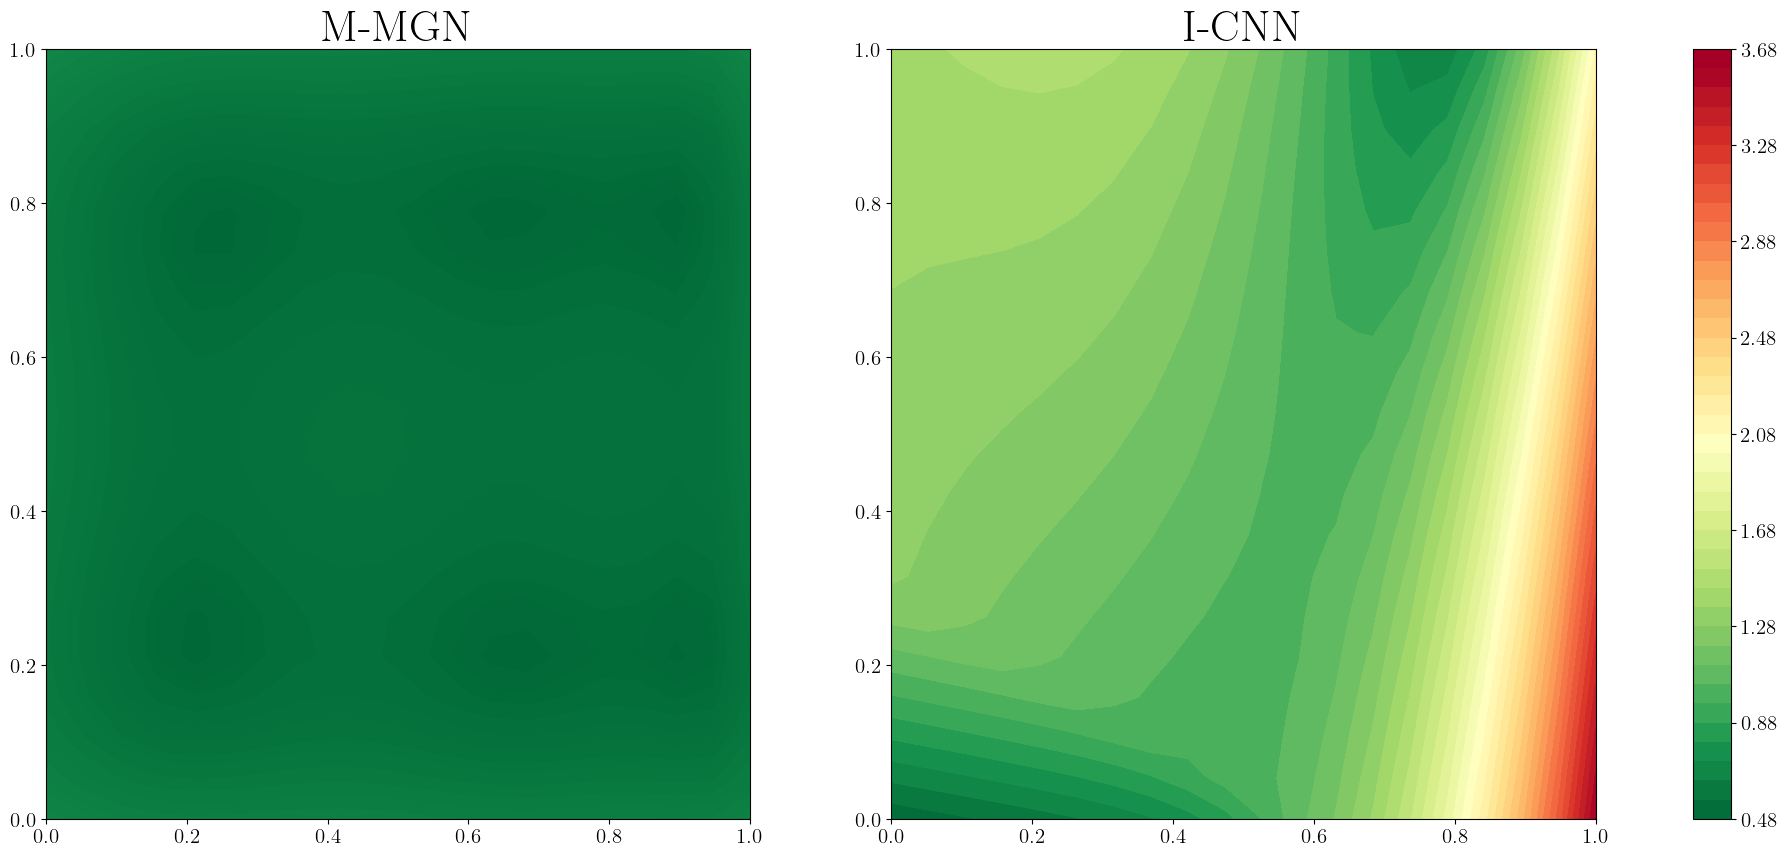

In [28]:

#plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(1, 2, figsize=(25,10))

xi = torch.linspace(0, 1, 20)
yi = torch.linspace(0, 1, 20)


#space = torch.rand(size=(1000,2))

Xi, Yi = torch.meshgrid(xi, yi, indexing="ij")  # Use "ij" or "xy" based on your needs
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = gradient(space)
#fig.suptitle('Error norm')

out_MMGN = trained_MMGN(space).detach().numpy()
z1 = (targ - out_MMGN).norm(dim=1).reshape(Xi.shape).T
out_ICCN = trained_ICCN(space).detach()
z2 = (targ - out_ICCN).norm(dim=1).reshape(Xi.shape).T

cmax = max(z1.max(),z2.max())

#CMGN & ICGN PLOT
#ax[0].contour(xi, yi, z1, levels=8, linewidths=0.5, colors='w')
cmgn_plt = ax[0].contourf(xi, yi, z1, levels=50, cmap="RdYlGn_r",vmax=cmax,)

#ax[1].contour(xi, yi, z2, levels=8, linewidths=0.5, colors='w')
icgn_plt = ax[1].contourf(xi, yi, z2, levels=50, cmap="RdYlGn_r",vmax=cmax)
#fig.colorbar(cntr1, ax=ax1)
# ax[0].scatter(x=space[:,0],y=space[:,1], c=z1,cmap='RdYlGn_r',vmin=0,vmax=cmax,s=48)
ax[0].set_title('M-MGN',fontsize=32)
ax[1].set_title('I-CNN',fontsize=32)

ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
#plt.tight_layout()
cbar = plt.colorbar(icgn_plt,ax=ax)
cbar.ax.tick_params(labelsize=15)

C:\Users\mouad\AppData\Local\Temp\ipykernel_28840\3022365275.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z1 = (targ - out_CMGN).norm(dim=1).reshape(Xi.shape).T


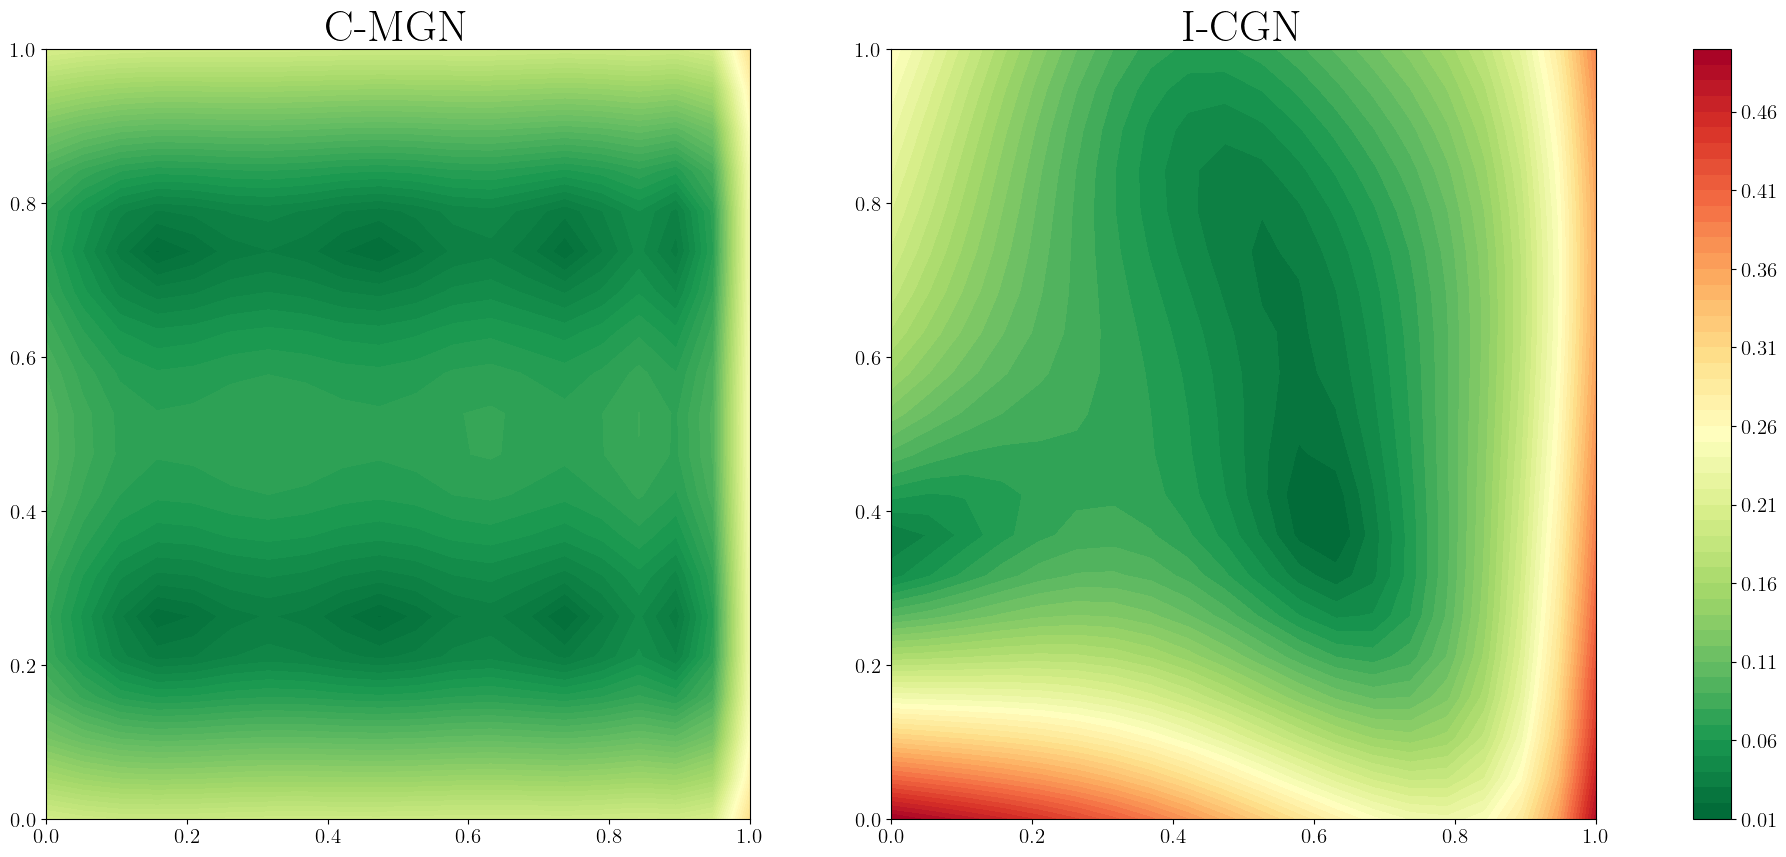

In [27]:

#plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(1, 2, figsize=(25,10))

xi = torch.linspace(0, 1, 20)
yi = torch.linspace(0, 1, 20)


#space = torch.rand(size=(1000,2))

Xi, Yi = torch.meshgrid(xi, yi, indexing="ij")  # Use "ij" or "xy" based on your needs
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = gradient(space)
#fig.suptitle('Error norm')

out_CMGN = trained_CMGN(space).detach().numpy()
z1 = (targ - out_CMGN).norm(dim=1).reshape(Xi.shape).T
out_ICGN = trained_ICGN(space).detach()
z2 = (targ - out_ICGN).norm(dim=1).reshape(Xi.shape).T

cmax = max(z1.max(),z2.max())

#CMGN & ICGN PLOT
#ax[0].contour(xi, yi, z1, levels=8, linewidths=0.5, colors='w')
cmgn_plt = ax[0].contourf(xi, yi, z1, levels=50, cmap="RdYlGn_r",vmax=cmax,)

#ax[1].contour(xi, yi, z2, levels=8, linewidths=0.5, colors='w')
icgn_plt = ax[1].contourf(xi, yi, z2, levels=50, cmap="RdYlGn_r",vmax=cmax)
#fig.colorbar(cntr1, ax=ax1)
# ax[0].scatter(x=space[:,0],y=space[:,1], c=z1,cmap='RdYlGn_r',vmin=0,vmax=cmax,s=48)
ax[0].set_title('C-MGN',fontsize=32)
ax[1].set_title('I-CGN',fontsize=32)

ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
#plt.tight_layout()
cbar = plt.colorbar(icgn_plt,ax=ax)
cbar.ax.tick_params(labelsize=15)

### Train & Validation Trainer

In [47]:
# Generate random samples in the unit square
num_samples = 10000
x = torch.rand(num_samples, 2)  # Shape: [num_samples, 2]

# Compute the true gradient ∇f(x)
true_grad = gradient(x)  # Shape: [num_samples, 2]
true_f = func(x)

dataset = TensorDataset(x, true_grad)
train_loader_grad = DataLoader(dataset, batch_size=32, shuffle=True)

dataset = TensorDataset(x, true_f)
train_loader_f = DataLoader(dataset, batch_size=32, shuffle=True)

In [48]:
mmgn_trainer = trainer.Trainer(
    dataset='2D_function',
    n_epochs=30,
    model=model_MMGN,
    true_fx=gradient,  # True gradient function
    criterion='L1loss',  # Use L1 loss for gradient approximation
    optimizer='Adam',
    lr=0.001,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

mmgn_trainer.train(train_loader_grad)
mmgn_trainer.plot_train_metrics()

Epoch 30 | Train Loss: 0.0550 | Train Cost: 3.5747 | Val Loss: 0.0000 | Val Cost: 0.0000: 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]
